##Flow through pipes

Calculates losses in pipeline, using Darcy-Weisbach friction model
Used Caleb Bell's python libray fluids

#Literature:

Clamond, Didier. “Efficient Resolution of the Colebrook Equation.” Industrial & Engineering Chemistry Research 48, no. 7 (April 1, 2009)
Crane Co. Flow of Fluids Through Valves, Fittings, and Pipe. Crane, 2009
Idelchik, I. E, and A. S Ginevski ̆ı. Handbook of Hydraulic Resistance. Redding, CT: Begell House, 2007
Caleb Bell, Fluids Documentation, October 2017, http://pierreproulx.espaceweb.usherbrooke.ca/fluids.pdf, http://fluids.readthedocs.io/

In [1]:
# import block

from fluids import *
from math import *
from matplotlib import pyplot as plt
import numpy as np
import os

In [2]:
#input - fluid data

ro=1025  #kg/m**3
kv=1.044  #cSt - Kinematic viscosity
nu = kv*0.000001 #conversion from cSt to m**2/s - https://www.cactus2000.de/uk/unit/massvis.shtml; http://convertall.bellz.org/js/

In [3]:
#input pipe data
pid = "NNNN"  #pipe ID/tag
pipe_material = "steel"  #pipe material
clean_pipe = "True"      #clean (new) pipe - True; False for used pipe
Dou = 80.0  #outer diameter of the pipe in mm
wt = 2.5  #wall thickness of the pipe in mm
Din = (Dou-2*wt)/1000  #inner diameter of the pipe in METERS [m]
material = nearest_material_roughness(pipe_material, clean=clean_pipe)
epsilon = material_roughness (material)
eD= epsilon/Din  #relative roughness of the pipe 
Length = 15  #length of the pipe [m]
Qmhmax=105 #max flow in cubic meters per hour [m**3/h]
Qstep = 5  #INTEGER!!! flow step in units of Qmh for reporting 

Am = (3.14*Din**2)/4

In [4]:
#input - pipe ends
Hent = 1  #height of entrance node of the pipe [m]
Hext = 3  #height of exit node of the pipe [m]
pent = 30000  #atmospheric pressure at entrance node of the pipe [Pa]
pext = 80000  #atmospheric pressure at the exit node of the pipe [Pa]

In [5]:
#input - valves, fittings, filters
#*****Number of Fittings*****
nsucbell = 0  #number of suction bells (beveled entrance)
nsuctwall = 0  #number of sharp entrances at the distance of the wall
nexit =0  #number of normal exits
nred = 0  #number of reducers/contractions
nenl = 0  #number of enlargements/diffusers
nbranch = 0  #number of runs through branch of the Tee or Wee
nmain = 0 #number of runs through main of the Tee or Wee
nb30 = 0  #number of rounded 30 deg. bends/elbows
nb45 = 0  #number of rounded 45 deg. bends/elbows
nb60 = 0  #number of rounded 60 deg. bends/elbows
nb90 = 0  #number of rounded 90 deg. bends/elbows
nb180 = 0 #number of rounded 180 deg. bends/elbows
nbg = 0  #number of rounded bends/elbows - input angle
nmiter = 0 #number of miter bends
#*****Number of Valves*****
nvgate = 0  #number of gate valves
nvangle = 0  #number of angle valves - all types
nvglobe = 0  #number of globe valves
nvswingc = 0  #number of swing check valves
nvliftc = 0  #number of lift check valves
nvtildic = 0  #number of tilting disc check valves
nvglstc = 0  #number of globe stop check valves
nvanstc = 0  #number of angle stop check valves
nvball = 0  #number of ball valves
nvdiweir = 0  #number of diaphragm weir valves
nvdiast = 0  #number of streight through diaphragm valves
nvfoot = 0  #number of foot or poppet valves
nvbutt = 0  #number of butterfly valves
nvplug = 0  #number of plug valves
norif = 0  #number of orifices
#*****Filters Data*****
nfre = 0  #number of filters with round edge screen
nfom = 0  #number of round edged open net/screen filters
nses = 0  #number of square wire or square bar or perforated plate screen filters
nseg = 0  #number of square grill or square bar screen or perforated plate with squared edges filters
nreg = 0  #number of rounded square grill or square bar screen or perforated plate with rounded edges filters
nfitt = nsucbell+nsuctwall+nexit+nred+nenl+nbranch+nmain+nb30+nb45+nb60+nb90+nb180+nbg+nmiter+nvgate+nvangle+nvglobe+nvswingc+nvliftc+nvtildic+nvglstc+nvanstc
nfitt += nvball+nvdiweir+nvdiast+nvfoot+nvbutt+nvplug+norif+nfre+nfom+nses+nreg

In [6]:
#file operation

os.mkdir(pid)
os.chdir(pid)
#filename = "results.txt"

#naming of arrays

Qcumh = [] #flow in cubic meters per hour
Q = []  #flow in cubic meters per second
Vp =[]  #velocity of the fluid
Re = []  #Reynolds number
fd = []  #Darcy friction factor
K = []  #fittings K-coefficient
deltaPf = [] #pressure drop due to fittings and friction in Pa (Pascal)
deltaHf = [] #Head loss due to fittings and friction in [m]
deltaP = [] #total pressure drop due to fittings, friction and geodesic height in Pa (Pascal)
deltaH = []#Head locc due to fittings, friction and geodesic height [m]
Kf = []  #friction K-coefficient
Ktot =[]  #total K coefficient(friction + fittings)
Hffitting = []

In [7]:
#calculation block
"""******
note:
!!!Some of functions may require additional input - use Fluid's Documentation
"""
for Qmh in range (0, Qmhmax):#m**3/h
    Qcumh.append(Qmh)
    Q.append(Qmh/3600.0)  #conversion to m**3/s
    Vp.append(Q[Qmh]/Am)  #flow velocity [m/s]
    
    #Retnolds number and friction factor calculation
    Re.append(Reynolds (V=Vp[Qmh], D=Din, rho=ro, nu=nu))
    if Re[Qmh] <= 2040:
        flow_type = "Laminar"
       # print "Flow is: ", flow_type
    else:
        flow_type = "Turbulent"
    #print "Flow is: ", flow_type
    
    # calculating Darcy pipe friction factor, using Clamond equation
    #fd[Qmh] = friction.Clamond (Re[Qmh], eD)
    if Re[Qmh]==0:
        fd.append(0)
    else:
        fd.append(friction.friction_factor(Re[Qmh], eD=eD, Method = "Clamond", Darcy = True, AvailableMethods = False))
    
    if Qmh ==0:
        Kf.append(0)
        K.append(0)
        Ktot.append(0)
        
    else:
        #*****f of Qmh:
     #"K"-loss (minor) calculation
        Kf.append (K_from_f (fd = fd[Qmh], L = Length, D = Din))   #loss in pipe due to friction
        #*****fittings loss coeff*****
        """
        Note:
        1. some input may be required for fittings, valves and filters functions to return correct values
        2. default values are, generally, not correct
        3. use fluid's documentation
        """
        K1 = 0
        K1 += nsucbell*fittings.entrance_beveled(Din, 100, 15) #suction bell - Din, length of bevel, angle of bevel
        K1 += nsuctwall*fittings.entrance_distance(Din, 20)  #entrance at distance of the wall - Din, t-distance of the wall
        K1 += nexit*fittings.exit_normal()
        K1 += nred*fittings.contraction_conical(Di1=Din, Di2=0.03, l=2*Din, fd=fd[Qmh])  #reducer, check lenght l; Di2-foll. pipe dia
        K1 += nenl*fittings.diffuser_conical(Di1=Din, Di2=0.1, l=4*Din, fd=fd[Qmh])  #enlargement, check lenght l; Di2-foll. pipe dia
        #through branch of Tee/Wee: angle - angle of the brunch [deg],QthroughRun = 1 
        K1 += nbranch*fittings.K_branch_converging_Crane(Din, Din, 1, Q[Qmh], angle=90) 
        #through headder of Tee/Wee: angle - angle of the branch [deg], QthroughBranch=1
        K1 += nmain*fittings.K_branch_diverging_Crane(Din, Din, Q[Qmh], 1, angle=90) 
        #*****bends and elbows*****
        K1 += nb30*fittings.bend_rounded(Di=Din, rc=2.5*Din, angle=30, fd=fd[Qmh]) #30deg: rc-bend radius, angle-bend angle
        K1 += nb45*fittings.bend_rounded(Di=Din, rc=2.5*Din, angle=45, fd=fd[Qmh]) #45deg: rc-bend radius, angle-bend angle
        K1 += nb60*fittings.bend_rounded(Di=Din, rc=2.5*Din, angle=60, fd=fd[Qmh]) #60deg: rc-bend radius, angle-bend angle
        K1 += nb90*fittings.bend_rounded(Di=Din, rc=2.5*Din, angle=90, fd=fd[Qmh]) #90deg: rc-bend radius, angle-bend angle
        K1 += nb180*fittings.bend_rounded(Di=Din, rc=2.5*Din, angle=180, fd=fd[Qmh]) #30deg: rc-bend radius, angle-bend angle
        K1 += nbg*fittings.bend_rounded(Di=Din, rc=2.5*Din, angle=22, fd=fd[Qmh]) #input bend angle: rc-bend radius, angle-bend angle
        K1 += nmiter*fittings.bend_miter(22.5)  #miter bend - input mitter angle (sigle segment)
       
        #*****Valves losses*****
        #gate valve D1[m] int. bore in the valve<=Din[m]; angle - internal reducer in the valve [deg]
        K1 += nvgate* fittings.K_gate_valve_Crane(D1=.1, D2=Din, angle=13.115, fd=fd[Qmh])
        #angle valve, (reduced seat or throttled); D1[m]<=Din - valve bore; style - 0, 1, 2 -see Crane
        K1 += nvangle*fittings.K_angle_valve_Crane(D1=0.9*Din, D2=Din, fd=fd[Qmh], style=0)
        #globe valve; D1[m] - internal valve bore
        K1 += nvglobe*fittings.K_globe_valve_Crane(D1=0.9*Din, D2=Din, fd=fd[Qmh])
        #swing check valve - angled or stright (True or False)
        K1 += nvswingc*fittings.K_swing_check_valve_Crane(fd=fd[Qmh], angled=False)
        #lift check valve - D1[m] <=Din - valve seat bore; angled - True or False
        K1 += nvliftc*fittings.K_lift_check_valve_Crane(D1=0.9*Din, D2=Din, fd=fd[Qmh], angled=True)
        #tilting disk check valve; angle=10-15 deg - angle of the tilting disk to the flow direction; nominally 5 or 15 degrees
        K1 += nvtildic*fittings.K_tilting_disk_check_valve_Crane(D=Din, angle=11, fd=fd[Qmh])
        #globe stop check valve: D1[m] <=Din - valve seat bore;style: 0-standard, 1-angled with restriction force to flow up, 2-same as 1 but with smaller restiction
        K1 += nvglstc*fittings.K_globe_stop_check_valve_Crane(D1=0.9*Din, D2=Din, fd=fd[Qmh], style=0)
        #angle stop check valve: D1[m] <=Din - valve seat bore;style: 0-standard, 1-angled with restriction force to flow up, 2-clearest flow area with no guides for the angle valve
        K1 += nvanstc*fittings.K_angle_stop_check_valve_Crane(D1=0.9*Din, D2=Din, fd=fd[Qmh], style=0)
        #ball valve: D1[m] <=Din - valve seat bore; angle[deg] - angle formed by the reducer in the valve
        K1 += nvball*fittings.K_ball_valve_Crane(D1=0.9*Din, D2=Din, angle = 50, fd=fd[Qmh])
        #diaphragm valve weir (style=0)
        K1 += nvdiweir*fittings.K_diaphragm_valve_Crane(fd=fd[Qmh], style=0)
        #diaphragm valve streight-through (style=1)
        K1 += nvdiast*fittings.K_diaphragm_valve_Crane(fd=fd[Qmh], style=1)
        #foot valve: style=0 - poppet disc; style=0 - hinged disc
        K1 += nvfoot*fittings.K_foot_valve_Crane(fd=fd[Qmh], style=0)
        #butterfly valve: style=0 - centric; style=1 - double offset; style=2 - triple offset
        K1 += nvbutt*fittings.K_butterfly_valve_Crane(D = Din, fd = fd[Qmh], style=0)
        #plug valve: D1[m] <=Din - valve seat bore; angle[deg]=formed by reducer in the valve; style:0-streight through; 1-3-way, flow streight through, 2-3 way, flow 90 deg.
        K1 += nvplug*fittings.K_plug_valve_Crane(D1 = 0.9*Din, D2 = Din, angle=50, fd=fd[Qmh], style=0)
        #*****Filters*****
        #round edge screen: alpha[-]-fraction of screen open to flow; angle[deg]-inclination, 0 is straight and 90 is parallel to flow
        K1 += nfre*filters.round_edge_screen(alpha = 0.5, Re = Re[Qmh], angle=0)
        #round edged open net/screen: alpha, angle-same as above; subtype - "round bar screen", "diamond pattern wire", "knotted net" or "knotless net"
        K1 += nfom*filters.round_edge_open_mesh(alpha=0.5, subtype="diamond pattern wire", angle=0)
        #square wire screen or square bar screen or perforated plate with squared edges: alpha-Fraction of screen open to flow
        K1 += nses*square_edge_screen(0.99)
        #square grill or square bar screen or perforated plate with squared edges of thickness l: l-thicknes, alpha-see above
        K1 += nseg*filters.square_edge_grill(alpha=0.45, l=0.02, Dh=None, fd=fd[Qmh])
        #rounded square grill or square bar screen or perforated plate with rounded edges of thickness l: same as above
        K1 += nreg*filters.round_edge_grill(alpha=0.45, l=0.02, Dh=None, fd=fd[Qmh])
        #orifice: Pipe_Dia[m], Orifice_Dia[m], Orifice_Length[m], Bevel_Angle
        K1 += norif*fittings.entrance_beveled_orifice(Din, 0.03, 0.05, 45)
        K.append(K1)  #K - fittings
        Ktot.append(Kf[Qmh]+K[Qmh])  #K - friction and fittings
           
    
    #*****Pressure and Head losses*****
    deltaPf.append(dP_from_K(Ktot[Qmh], ro, Vp[Qmh]))  #pressure drop due to fittings and friction in Pa (Pascal)
    deltaHf.append(deltaPf[Qmh]/(9.81*ro))  #Head loss due to fittings and friction in [m]
    deltaP.append(deltaPf[Qmh]+ro*9.81*(Hext-Hent)+(pext-pent))   #total pressure loss [Pa]
    deltaH.append(deltaP[Qmh]/(9.81*ro))  #total head loss [m]
    Hffitting.append(dP_from_K(K[Qmh], ro, Vp[Qmh])/(9.81*ro))
    
HQcoef = np.polyfit(Qcumh, deltaH, 2) 

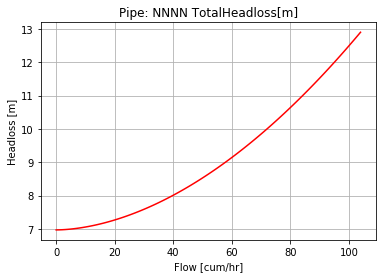

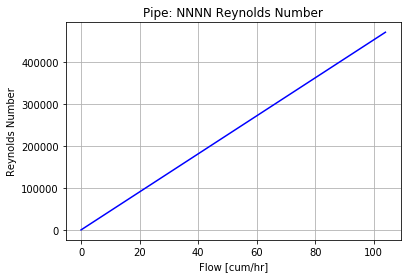

END


In [8]:
#preparing and writing report

fn3=open ("report.txt", 'a')
file.write(fn3, "**************************"+"\nPipe Tag: "+pid+"\n**************************")
file.write(fn3, "Friction Model: Darcy-Weisbach, with Clamond solution; minor losses calculated as per Crane TP-410m")
file.write(fn3, "\nSpecific gravity of the fluid [kg/m^3]: "+str (ro) + "\nFluid kinematic viscosity [cSt]: "+str (kv)+"\nPipe material: "+ pipe_material+"\nClean (new) pipe? "+ clean_pipe)
file.write(fn3,  "\nPipe Outer Dia x wall thickness [mm]: "+ str(Dou)+ "x"+str(wt) + "\nHeight of entering node x Height of exit node[m]: "+ str(Hent)+ "x"+str(Hext) + "\nAtm. pressure in enetring node x Atm. pressure in exit node[Pa]: "+str(pent) +"x"+str(pext)+"\nLength of the pipe [m]: "+str(Length))
file.write(fn3, "\nRelative roughness of the pipe: "+str(eD))
file.write(fn3, "\nTotal number of fittings in line: " + str(nfitt))
file.write(fn3, "\nAprox Q-H coef in H[m]=A*Q[cumh]**2+B*Q[cumh]+C as [A, B , C]: "+ str(HQcoef))
file.write(fn3, "\nQ[m**3/h], Q[m**3/s], Velocity[m/s]Re, Friction[Clamond], K-friction, K-fittings, Total Pressure Drop[Pa], Total Height Loss[m], Height Loss from Fittings[m]")

#writing EPANET HEADLOSS curve-file (*.crv) as input for GPV-valve
fn1 = open(pid+".crv", 'a')
file.write(fn1, "EPANET Curve Data for pipe " +pid + "\nHEADLOSS" +"\n" ) # 2 spaces

for Qmh in range (0, Qmhmax, Qstep):
    file.write(fn3, "\n"+str(Qmh)+','+str(Q[Qmh])+',' +str(Vp[Qmh])+','+str(Re[Qmh])+','+str(Kf[Qmh])+','+str(K[Qmh])+',' +str(deltaP[Qmh])+','+str(deltaH[Qmh])+','+str(Hffitting[Qmh]))
    file.write(fn1, "\n" +str(Qmh)+"  "+str(Hffitting[Qmh]))
fn3.close()   
fn1.close()  

#plotting   
fnameH=pid+"_QH.png"
fnameRe=pid+"_QRe.png"
plt.plot(Qcumh,deltaH, color="red")
plt.title("Pipe: "+pid+" TotalHeadloss[m]")
plt.xlabel("Flow [cum/hr]")
plt.ylabel("Headloss [m]")
plt.grid(True)
plt.savefig(fnameH)
plt.show()
plt.close()
plt.plot(Qcumh,Re, color="blue")
plt.title("Pipe: "+pid+ " Reynolds Number")
plt.xlabel("Flow [cum/hr]")
plt.ylabel("Reynolds Number")
plt.grid(True)
plt.savefig(fnameRe)
plt.show()
plt.close()

print"END"